# ROC / AUC in classification problem

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.feature_selection import VarianceThreshold

In [3]:
df = pd.read_csv("D:/Python DataScience/Feature Selection/santander-train.csv",nrows=20000)

In [4]:
X = df.drop(['TARGET'],axis=1)
y = df['TARGET']
X_train ,X_test ,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0,stratify=y)
constant_filter = VarianceThreshold(threshold=0.01)
constant_filter.fit(X_train)
X_train_filter = constant_filter.transform(X_train)
X_test_filter = constant_filter.transform(X_test)
X_train_T = X_train_filter.T
X_test_T = X_test_filter.T
X_train_T = pd.DataFrame(X_train_T)
X_test_T = pd.DataFrame(X_test_T)
duplicated_features = X_train_T.duplicated()
features_to_keep = [not index for index in duplicated_features]
X_train_unique = X_train_T[features_to_keep].T
X_test_unique = X_test_T[features_to_keep].T

In [18]:
X_train_unique.shape, X_test_unique.shape

((16000, 227), (4000, 227))

## ROC Curve for Classification

In [23]:
%%time
roc_auc = []
for feature in X_train_unique.columns:
    clf = RandomForestClassifier(n_estimators=100,random_state=0)
    clf.fit(X_train_unique[feature].to_frame(),y_train)
    y_pred = clf.predict(X_test_unique[feature].to_frame())
    roc_auc.append(roc_auc_score(y_test,y_pred))
    
    

Wall time: 1min 42s


In [25]:
roc_values = pd.Series(roc_auc)
roc_values.index = X_train_unique.columns
roc_values.sort_values(ascending=False,inplace=True)

In [26]:
roc_values

244    0.507660
107    0.504832
104    0.502937
6      0.502807
155    0.502546
         ...   
18     0.496873
211    0.496742
105    0.495960
12     0.495700
5      0.495700
Length: 227, dtype: float64

Observation - 
If ROC/AUC is less then 0.5 then the features are not giving good information just random predictions

We drop the features which have ROC AUC value less then 0.5

In [27]:
selected = roc_values[roc_values>0.5]

In [29]:
X_train_roc = X_train_unique[selected.index]
X_test_roc = X_test_unique[selected.index]

## Model Build

In [30]:
def runRandomForest(X_train,X_test,y_train,y_test):
    clf = RandomForestClassifier(n_estimators=100,random_state=0,n_jobs=-1)
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    print("Accuracy : " ,accuracy_score(y_test,y_pred))
    

In [31]:
%%time
runRandomForest(X_train_roc,X_test_roc,y_train,y_test)

Accuracy :  0.95275
Wall time: 1.46 s


In [32]:
%%time
runRandomForest(X_train,X_test,y_train,y_test)

Accuracy :  0.9585
Wall time: 3.11 s


## Regression and MSE

In [33]:
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score


In [36]:
data = load_boston()
X = pd.DataFrame(data.data,columns=data.feature_names)

In [37]:
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [40]:
y = data.target

In [42]:
X_train ,X_test ,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [61]:
mse = []
for feature in X_train.columns:
    clf = LinearRegression()
    clf.fit(X_train[feature].to_frame(),y_train)
    y_pred = clf.predict(X_test[feature].to_frame())
    mse.append(mean_squared_error(y_test,y_pred))

In [62]:
mse

[76.38674157646072,
 84.66034377707905,
 77.02905244667242,
 79.36120219345942,
 76.95375968209433,
 46.907351627395315,
 80.3915476111525,
 82.61874125667718,
 82.46499985731933,
 78.30831374720843,
 81.79497121208003,
 77.75285601192718,
 46.33630536002592]

In [63]:
mse =pd.Series(mse,index=X_train.columns)

In [65]:
mse.sort_values(ascending=False,inplace=True)

In [66]:
mse

ZN         84.660344
DIS        82.618741
RAD        82.465000
PTRATIO    81.794971
AGE        80.391548
CHAS       79.361202
TAX        78.308314
B          77.752856
INDUS      77.029052
NOX        76.953760
CRIM       76.386742
RM         46.907352
LSTAT      46.336305
dtype: float64

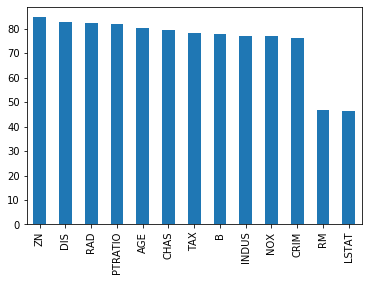

In [67]:
mse.plot.bar()

In [68]:
X_train_mse = X_train[['RM','LSTAT']]
X_test_mse = X_test[['RM','LSTAT']]

In [69]:
%%time
model = LinearRegression()
model.fit(X_train_mse,y_train)
y_pred = model.predict(X_test_mse)


Wall time: 5.5 ms


In [70]:
print('r2 score : ',r2_score(y_test,y_pred)) 

r2 score :  0.5409084827186417


In [71]:
print('rmse : ',np.sqrt(mean_squared_error(y_test,y_pred)))

rmse :  6.114172522817782
